In [1]:
!pip install gdown

In [2]:
!gdown 1A1lx_Vvu_hWPrGtjeNmXlxKbnSvI_hh2

Downloading...
From: https://drive.google.com/uc?id=1A1lx_Vvu_hWPrGtjeNmXlxKbnSvI_hh2
To: /content/data_full_spoiled_extended.json
100% 1.52M/1.52M [00:00<00:00, 41.9MB/s]


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
import json

with open("data_full_spoiled_extended.json") as f:
    data = json.load(f)

len(data), data.keys()

(4, dict_keys(['train', 'val', 'oos_train', 'oos_val']))

In [6]:
def get_ds(data):
    return zip(*data)

def merge_ds(data1, data2):
    return [*next(data1), *next(data2)], [*next(data1), *next(data2)]

train_text, train_labels = merge_ds(get_ds(data["train"]), get_ds(data["oos_train"]))
val_text, val_labels = merge_ds(get_ds(data["val"]), get_ds(data["oos_val"]))
# train_text, train_labels = get_ds(data["train"])
# val_text, val_labels = get_ds(data["val"])
train_text[:5], train_labels[:5]

(['what expression would i use to say i love you if i were an italian',
  "can you tell me how to say 'i do not speak much spanish', in spanish",
  "what is the equivalent of, 'life is good' in french",
  "tell me how to say, 'it is a beautiful morning' in italian",
  'if i were mongolian, how would i say that i am a tourist'],
 ['translate', 'translate', 'translate', 'translate', 'translate'])

In [7]:
len(train_text), len(val_text)

(15113, 3104)

In [8]:
train_classes, val_classes = set(train_labels), set(val_labels)
len(train_classes), len(val_classes)

(151, 151)

In [9]:
classes = list(train_classes & val_classes)
classes[:5], len(classes)

(['alarm',
  'meal_suggestion',
  'ingredient_substitution',
  'maybe',
  'nutrition_info'],
 151)

In [10]:
with open("classes.txt", "w") as f:
    f.write("\n".join(classes))

In [11]:
from collections import Counter

labels_count = Counter(train_labels)
sorted_labels_count = labels_count.most_common()
print(*sorted_labels_count[:10], sep="\n", end="\n\n\n")
print(*sorted_labels_count[-10:], sep="\n")

('oos', 111)
('improve_credit_score', 109)
('yes', 109)
('whisper_mode', 108)
('schedule_meeting', 107)
('mpg', 106)
('expiration_date', 106)
('restaurant_reviews', 105)
('international_fees', 105)
('change_volume', 105)


('credit_score', 96)
('share_location', 96)
('next_holiday', 96)
('what_can_i_ask_you', 95)
('routing', 95)
('date', 95)
('recipe', 95)
('schedule_maintenance', 94)
('replacement_card_duration', 94)
('taxes', 94)


In [12]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(3407)
torch.cuda.manual_seed_all(3407)

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from peft import LoraConfig, PeftModel, get_peft_model

def load_model(name="microsoft/deberta-v3-base", num_labels=151):
    tokenizer = AutoTokenizer.from_pretrained(name)
    model = AutoModelForSequenceClassification.from_pretrained(name, num_labels=num_labels)
    model.to(device)
    # target_modules = ["query_proj", "value_proj", "dense"]
    # config = LoraConfig(
    #     r=16, lora_alpha=16, target_modules=target_modules, lora_dropout=0.1, bias="none", task_type="SEQ_CLS"
    # )
    # lora_model = get_peft_model(model, config).to(device)
    return tokenizer, model

tokenizer, model = load_model("FacebookAI/roberta-base", num_labels=len(classes))
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [14]:
lens = [len(tokenizer(i)["input_ids"]) for i in [*train_text, *val_text]]
sum(lens) / len(lens)

11.09578964703299

In [15]:
max(lens)

37

In [16]:
def preproc(text, tokenizer, max_length=64):
    inputs = tokenizer(
        text,
        max_length=max_length,
        add_special_tokens=True,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    return inputs["input_ids"], inputs["attention_mask"]

preproc(train_text[0], tokenizer)

(tensor([[    0, 12196,  8151,    74,   939,   304,     7,   224,   939,   657,
             47,   114,   939,    58,    41,    24, 21999,     2,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1]]),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [17]:
train_input_ids, train_attention_mask = zip(*map(lambda x: preproc(x, tokenizer), train_text))
train_input_ids, train_attention_mask = torch.cat(train_input_ids), torch.cat(train_attention_mask)

val_input_ids, val_attention_mask = zip(*map(lambda x: preproc(x, tokenizer), val_text))
val_input_ids, val_attention_mask = torch.cat(val_input_ids), torch.cat(val_attention_mask)
train_input_ids[0]

tensor([    0, 12196,  8151,    74,   939,   304,     7,   224,   939,   657,
           47,   114,   939,    58,    41,    24, 21999,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])

In [18]:
label2id = {label: i for i, label in enumerate(classes)}
id2label = {i: label for i, label in enumerate(classes)}
label2id["yes"]

58

In [19]:
train_targets = torch.cat(list(map(lambda x: torch.LongTensor([label2id[x]]), train_labels)))
val_targets = torch.cat(list(map(lambda x: torch.LongTensor([label2id[x]]), val_labels)))
train_targets[0]

tensor(117)

In [20]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(train_input_ids, train_attention_mask, train_targets)
val_ds = TensorDataset(val_input_ids, val_attention_mask, val_targets)
batch_size = 100
train_dl, val_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True), DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True)

In [21]:
train_ds[0]

(tensor([    0, 12196,  8151,    74,   939,   304,     7,   224,   939,   657,
            47,   114,   939,    58,    41,    24, 21999,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor(117))

In [22]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()

num_training_steps = epochs * len(train_dl)

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dl) * 0.5, num_training_steps=num_training_steps)

In [23]:
from tqdm import tqdm
import gc

def train(model, train_dl, criterion, optimizer, scheduler=None):
    model.train()
    train_loss = 0
    for x, atten_mask, y in train_dl:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        atten_mask = atten_mask.to(device)
        out = model(x, attention_mask=atten_mask).logits
        loss = criterion(out, y)
        train_loss += loss.item()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        gc.collect()
        torch.cuda.empty_cache()
    return train_loss / len(train_dl)

In [24]:
from sklearn.metrics import *
import numpy as np

@torch.no_grad()
def val(model, val_dl, criterion):
    model.eval()
    val_loss, val_acc = 0, 0
    for x, atten_mask, y in val_dl:
        x, y = x.to(device), y.to(device)
        atten_mask = atten_mask.to(device)
        out = model(x, attention_mask=atten_mask).logits
        loss = criterion(out, y)
        val_loss += loss.item()
        pred = np.argmax(out.cpu().detach().numpy(), axis=1)
        true = y.cpu().detach().numpy()
        val_acc += accuracy_score(true, pred)
    gc.collect()
    torch.cuda.empty_cache()
    return val_loss / len(val_dl), val_acc / len(val_dl)

In [25]:
best_epoch, best_val_acc = 0, 0

train_losses, val_losses, val_accs = [], [], []
for epoch in tqdm(range(1, epochs + 1)):
    print("\n" + "=" * 5 + f"Epoch {epoch}/{epochs}" +  "=" * 5)
    train_loss = train(model, train_dl, criterion, optimizer, scheduler)
    print(f"Train loss {train_loss}\n")
    val_loss, val_acc = val(model, val_dl, criterion)
    model.save_pretrained(f"roberta/epoch_{epoch}")
    if val_acc > best_val_acc:
        best_epoch, best_val_acc = epoch, val_acc
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Val loss {val_loss} acc {val_acc}")

  0%|          | 0/10 [00:00<?, ?it/s]


=====Epoch 1/10=====
Train loss 2.6255955331419645



 10%|█         | 1/10 [02:39<23:55, 159.50s/it]

Val loss 0.8689652290195227 acc 0.8125000000000001

=====Epoch 2/10=====
Train loss 1.104568366157381



 20%|██        | 2/10 [05:21<21:29, 161.22s/it]

Val loss 0.5482781874015927 acc 0.8978124999999999

=====Epoch 3/10=====
Train loss 0.9681997620745709



 30%|███       | 3/10 [08:04<18:52, 161.85s/it]

Val loss 0.5044704249594361 acc 0.9025000000000001

=====Epoch 4/10=====
Train loss 0.8505320074526888



 40%|████      | 4/10 [10:48<16:17, 162.83s/it]

Val loss 0.4376700441353023 acc 0.91875

=====Epoch 5/10=====
Train loss 0.7564347486354803



 50%|█████     | 5/10 [13:34<13:39, 163.91s/it]

Val loss 0.3894937818404287 acc 0.9306250000000001

=====Epoch 6/10=====
Train loss 0.6735349385754058



 60%|██████    | 6/10 [16:17<10:54, 163.54s/it]

Val loss 0.41493783867917955 acc 0.9278124999999999

=====Epoch 7/10=====
Train loss 0.6060841193324641



 70%|███████   | 7/10 [19:00<08:09, 163.27s/it]

Val loss 0.3600372930523008 acc 0.938125

=====Epoch 8/10=====
Train loss 0.5325757439591383



 80%|████████  | 8/10 [21:44<05:27, 163.61s/it]

Val loss 0.38596580107696354 acc 0.9303124999999999

=====Epoch 9/10=====
Train loss 0.45724290227027314



 90%|█████████ | 9/10 [24:27<02:43, 163.30s/it]

Val loss 0.3898043460212648 acc 0.92625

=====Epoch 10/10=====
Train loss 0.3965199605414742



100%|██████████| 10/10 [27:09<00:00, 162.97s/it]

Val loss 0.38089202670380473 acc 0.9346875


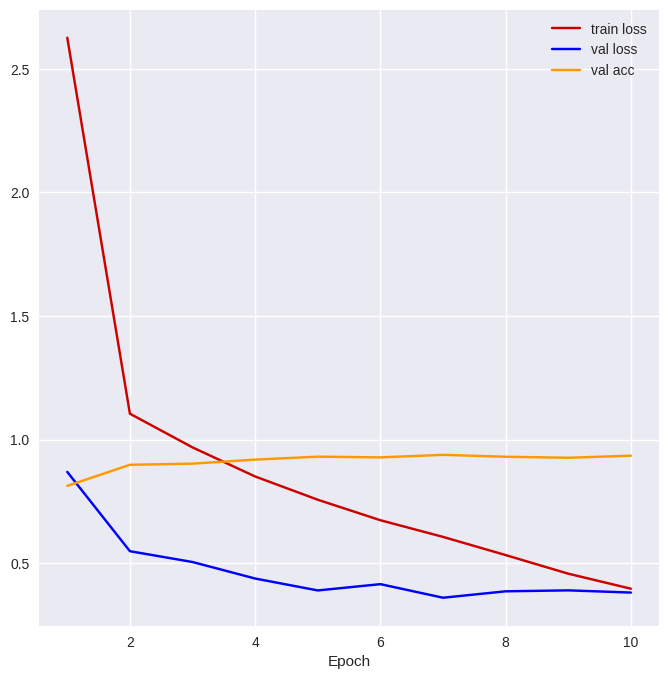

In [28]:
import matplotlib.pyplot as plt

arr_epochs = np.arange(1, epochs + 1)
plt.figure(figsize=(8, 8))
plt.style.use("seaborn-v0_8")
plt.plot(arr_epochs, train_losses, c="#cc0000", label="train loss")
plt.plot(arr_epochs, val_losses, c="#0000ff", label="val loss")
plt.plot(arr_epochs, val_accs, c="#ff9900", label="val acc")
plt.xlabel("Epoch")
plt.legend();

In [29]:
model.from_pretrained(f"roberta/epoch_{best_epoch}", local_files_only=True)
model.to(device)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [30]:
gc.collect()
torch.cuda.empty_cache()
model.to(device)

preds, trues = [], []
for x, atten_mask, y in val_dl:
    with torch.no_grad():
        x, y = x.to(device), y.to(device)
        atten_mask = atten_mask.to(device)
        out = model(x, attention_mask=atten_mask).logits
        loss = criterion(out, y)
        pred = np.argmax(out.cpu().detach().numpy(), axis=1)
        true = y.cpu().detach().numpy()
        preds.extend(pred)
        trues.extend(true)


gc.collect()
torch.cuda.empty_cache()

In [31]:
d = {}
for i in range(len(preds)):
    if preds[i] != trues[i]:
        if id2label[preds[i]] not in d:
            d[id2label[preds[i]]] = 1
        else:
            d[id2label[preds[i]]] += 1

sorted(d.items(), key=lambda x: -x[1])[:10]

[('todo_list', 6),
 ('definition', 6),
 ('what_can_i_ask_you', 6),
 ('income', 5),
 ('freeze_account', 5),
 ('oos', 5),
 ('yes', 4),
 ('order', 4),
 ('where_are_you_from', 4),
 ('change_user_name', 4)]

In [32]:
path = "dirty"

print(classification_report(trues, preds))
with open(f"/content/drive/MyDrive/Colab Notebooks/Sirius/project/{path}_classification_report.txt", "w") as f:
    f.write(classification_report(trues, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.91      1.00      0.95        20
           2       0.91      1.00      0.95        20
           3       1.00      0.95      0.97        20
           4       1.00      0.65      0.79        20
           5       1.00      1.00      1.00        20
           6       0.95      0.95      0.95        20
           7       1.00      0.75      0.86        20
           8       0.95      1.00      0.98        20
           9       0.95      1.00      0.98        20
          10       0.95      0.95      0.95        20
          11       0.87      1.00      0.93        20
          12       0.95      1.00      0.98        20
          13       0.87      1.00      0.93        20
          14       0.91      1.00      0.95        20
          15       0.90      0.90      0.90        20
          16       1.00      1.00      1.00        20
          17       0.95    

In [33]:
!gdown 1UlYk6XdzwK4U1AuPvmBv5i1Odx7K9puZ

Downloading...
From: https://drive.google.com/uc?id=1UlYk6XdzwK4U1AuPvmBv5i1Odx7K9puZ
To: /content/label_desc_context_nearest_many.csv
100% 41.5k/41.5k [00:00<00:00, 93.1MB/s]


In [34]:
import pandas as pd

desc = pd.read_csv("label_desc_context_nearest_many.csv")
desc

,intent,text,description,nearest_labels
0,accept_reservations,does spago in beverly hills allow customers to...,Requests to determine if a specific restaurant...,"['definition', 'travel_alert', 'restaurant_res..."
1,account_blocked,my account looks to be blocked and i have no i...,Requests for information about why a bank acco...,"['balance', 'freeze_account', 'card_declined']"
2,alarm,i'd like alarms set for 11am and 132pm,"Requests to set, update, or review alarms for ...","['translate', 'timer']"
3,application_status,what is the present status of my credit card a...,Requests for updates on the status of an appli...,"['credit_limit', 'order_status', 'credit_limit..."
4,apr,is the apr on my card that ends 1234 what it s...,Requests for information about the Annual Perc...,"['new_card', 'credit_limit', 'interest_rate']"
...,...,...,...,...
146,where_are_you_from,what place were you born at,Requests about the assistant's origin or creat...,"['change_user_name', 'what_can_i_ask_you', 'wh..."
147,whisper_mode,set up whisper mode,"Requests to activate a whisper mode, where the...","['change_user_name', 'change_speed', 'change_v..."
148,who_do_you_work_for,do you work for another person,"Requests to know the assistant's affiliation, ...","['application_status', 'change_user_name', 'wh..."
149,who_made_you,who is your designer,"Requests about the creator, designer, or under...","['fun_fact', 'change_user_name', 'where_are_yo..."


In [35]:
label2desc = {row.intent: row.description for i, row in desc.iterrows() if row.intent != "oos"}
list(label2desc.items())[:5]

[('accept_reservations',
  'Requests to determine if a specific restaurant or establishment allows reservations. Users may seek this information before attempting to book a table.'),
 ('account_blocked',
  'Requests for information about why a bank account or service has been blocked. Users may seek assistance in understanding the reason for the hold and how to resolve it.'),
 ('alarm',
  'Requests to set, update, or review alarms for specific times. Users may provide detailed instructions for single or multiple alarms across different time periods.'),
 ('application_status',
  'Requests for updates on the status of an application, such as a credit card or other formal process. Users may ask if their application has been approved, is under review, or requires additional action.'),
 ('apr',
  'Requests for information about the Annual Percentage Rate (APR) on a credit card. Users may ask if the rate is appropriate based on their credit score or inquire about the APR for a specific card.

In [36]:
with open(f"/content/drive/MyDrive/Colab Notebooks/Sirius/project/{path}/tokenizer/label2desc.json", "w") as f:
    json.dump(label2desc, f, indent=2)

In [38]:
# model.push_to_hub("dirty-roberta-base")

In [39]:
# model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/Sirius/project/best")
tokenizer.save_pretrained(f"/content/drive/MyDrive/Colab Notebooks/Sirius/project/{path}/tokenizer/tokenizer")

with open(f"/content/drive/MyDrive/Colab Notebooks/Sirius/project/{path}/tokenizer/id2label.json", "w") as f:
    json.dump(id2label, f, indent=2)

In [40]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 97.6 MB/s eta 0:00:00


In [41]:
torch.onnx.export(
    model.cpu(), (torch.rand(1, 5).long(), torch.rand(1, 5).long()),
    f"/content/drive/MyDrive/Colab Notebooks/Sirius/project/{path}/model.onnx",
    input_names=['input_ids', 'attention_masks'],
    output_names=['outputs'],
    opset_version=15,
    dynamic_axes={
        'input_ids': {
            0: 'batch_size',
            1: 'seq_len'
        },
        'attention_masks': {
            0: 'batch_size',
            1: 'seq_len'
        },
        'outputs': {
            0: 'batch_size'
        }
    }
)